In [6]:
import scanpy as sc
adata = sc.read_h5ad("../data/output-dgi-10-10-20MAY2025.h5ad")
adata.layers["counts"] = adata.layers["counts"].todense()
adata = adata[adata.obs["folder"].eq("05-27")]

/home/jhaberbe/Projects/Personal/TokenGT/.venv/lib/python3.13/site-packages/anndata/_core/anndata.py:1756: UserWarning: Observation names are not unique. To make them unique, call `.obs_names_make_unique`.
  utils.warn_names_duplicates("obs")
/home/jhaberbe/Projects/Personal/TokenGT/.venv/lib/python3.13/site-packages/anndata/_core/storage.py:39: ImplicitModificationWarning: Layer 'counts' should not be a np.matrix, use np.ndarray instead.
  warnings.warn(msg, ImplicitModificationWarning)


In [12]:
X = torch.tensor(adata.layers["transcript"])

# Encoding 

In [45]:
import torch
import torch.nn as nn
import torch.nn.functional as F
from torch.distributions import NegativeBinomial

class VariationalAutoencoder(nn.Module):
    def __init__(self, input_dim, latent_dim, hidden_dim=128):
        super().__init__()
        self.fc1 = nn.Linear(input_dim, hidden_dim)
        self.fc_mu = nn.Linear(hidden_dim, latent_dim)
        self.fc_logvar = nn.Linear(hidden_dim, latent_dim)

        self.fc2 = nn.Linear(latent_dim, hidden_dim)
        self.fc_out = nn.Linear(hidden_dim, input_dim)

        self.log_dispersion = nn.Parameter(torch.zeros(input_dim))

    def encode(self, x):
        h = F.relu(self.fc1(x))
        mu = self.fc_mu(h)
        logvar = self.fc_logvar(h)
        return mu, logvar

    def reparameterize(self, mu, logvar):
        std = torch.exp(0.5 * logvar)
        eps = torch.randn_like(std)
        return mu + eps * std

    def decode(self, z):
        h = F.relu(self.fc2(z))
        # Output log-mean: we will build logits manually
        log_mu = self.fc_out(h)  # not softplus here!
        return log_mu

    def forward(self, x):
        mu, logvar = self.encode(x)
        z = self.reparameterize(mu, logvar)
        log_mu = self.decode(z)

        # infer size factors as log(total count / mean total count)
        total_counts = x.sum(dim=1, keepdim=True).clamp(min=1.0)
        log_size_factors = torch.log(total_counts) - torch.log(total_counts.mean())

        return log_mu, mu, logvar, log_size_factors

    def negative_binomial_log_likelihood(self, x, log_mu, log_size_factors):
        theta = torch.exp(self.log_dispersion)  # [input_dim]
        
        # Add log-size-factor to log-mean to form offset-adjusted logits
        adjusted_log_mu = log_mu + log_size_factors  # broadcast over input_dim

        logits = adjusted_log_mu - torch.log(theta + torch.exp(adjusted_log_mu))
        nb_dist = NegativeBinomial(total_count=theta, logits=logits)
        log_prob = nb_dist.log_prob(x).sum(dim=-1)
        return log_prob.mean()

    def info_nce_loss(self, z, temperature=0.1):
        z = F.normalize(z, dim=1)
        sim_matrix = torch.matmul(z, z.T) / temperature
        batch_size = z.size(0)
        mask = torch.eye(batch_size, dtype=torch.bool, device=z.device)
        exp_sim = torch.exp(sim_matrix).masked_fill(mask, 0)
        numerator = torch.exp(torch.diagonal(sim_matrix))
        denominator = exp_sim.sum(dim=1)
        return (-torch.log(numerator / denominator)).mean()


In [52]:
from tqdm import tqdm
import torch
import torch.optim as optim

def kl_divergence(mu, logvar):
    # KL divergence between q(z|x) = N(mu, sigma) and p(z) = N(0,1)
    return -0.5 * torch.sum(1 + logvar - mu.pow(2) - logvar.exp(), dim=1).mean()

def train_vae(vae, X, epochs=100, batch_size=16, lr=1e-3, device='cpu',
              recon_weight=1.0, kl_weight=1.0, info_nce_weight=1.0):
    vae.to(device)
    optimizer = optim.Adam(vae.parameters(), lr=lr)
    
    dataset = torch.utils.data.TensorDataset(X)
    dataloader = torch.utils.data.DataLoader(dataset, batch_size=batch_size, shuffle=True)
    
    vae.train()
    for epoch in range(1, epochs + 1):
        total_loss = 0
        total_recon = 0
        total_kl = 0
        total_info_nce = 0
        for (batch,) in tqdm(dataloader):
            batch = batch.to(device).float()
            optimizer.zero_grad()
            
            log_mu, mu, logvar, log_sf = vae(batch)
            recon_loss = vae.negative_binomial_log_likelihood(batch, log_mu, log_sf)
            
            # KL divergence loss
            kl_loss = kl_divergence(mu, logvar)
            
            # InfoNCE loss on latent
            z = vae.reparameterize(mu, logvar)
            info_nce_loss = vae.info_nce_loss(z)
            
            # Combine losses
            loss = (recon_weight * recon_loss) + (kl_weight * kl_loss) + (info_nce_weight * info_nce_loss)
            
            loss.backward()
            optimizer.step()
            
            total_loss += loss.item() * batch.size(0)
            total_recon += recon_loss.item() * batch.size(0)
            total_kl += kl_loss.item() * batch.size(0)
            total_info_nce += info_nce_loss.item() * batch.size(0)
        
        n = len(dataloader.dataset)
        print(f"Epoch {epoch} | Loss: {total_loss / n:.4f} | Recon: {total_recon / n:.4f} | KL: {total_kl / n:.4f} | InfoNCE: {total_info_nce / n:.4f}")
        
    return vae


In [54]:
input_dim = 366
latent_dim = 32
epochs = 200

vae = VariationalAutoencoder(input_dim, latent_dim)
trained_vae = train_vae(vae, X, epochs=epochs, batch_size=256)


 12%|█▎        | 34/272 [00:23<02:46,  1.43it/s]


ValueError: Expected parameter logits (Tensor of shape (256, 366)) of distribution NegativeBinomial(total_count: torch.Size([256, 366]), logits: torch.Size([256, 366])) to satisfy the constraint Real(), but found invalid values:
tensor([[nan, nan, nan,  ..., nan, nan, nan],
        [nan, nan, nan,  ..., nan, nan, nan],
        [nan, nan, nan,  ..., nan, nan, nan],
        ...,
        [nan, nan, nan,  ..., nan, nan, nan],
        [nan, nan, nan,  ..., nan, nan, nan],
        [nan, nan, nan,  ..., nan, nan, nan]], grad_fn=<SubBackward0>)

In [40]:
adata.obsm["X_vae"] = vae(X.float())[0].detach().numpy()

/tmp/ipykernel_3360473/2002613765.py:1: ImplicitModificationWarning: Setting element `.obsm['X_vae']` of view, initializing view as actual.
  adata.obsm["X_vae"] = vae(X.float())[0].detach().numpy()


/home/jhaberbe/Projects/Personal/TokenGT/.venv/lib/python3.13/site-packages/tqdm/auto.py:21: TqdmWarning: IProgress not found. Please update jupyter and ipywidgets. See https://ipywidgets.readthedocs.io/en/stable/user_install.html
  from .autonotebook import tqdm as notebook_tqdm


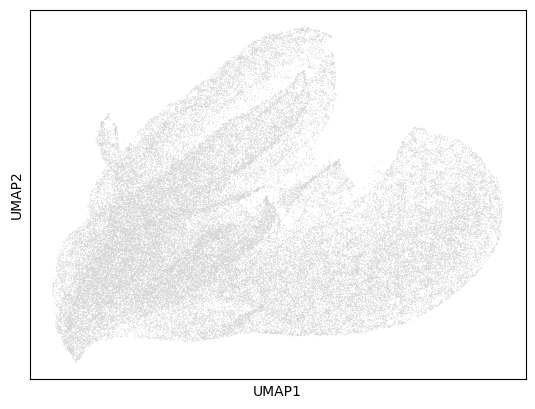

In [41]:
sc.pp.neighbors(adata, use_rep="X_vae")
sc.tl.umap(adata)
sc.pl.umap(adata)